Le problème est le suivant:
Il s'agit d'une vidéo corrompue que l'on trouvera sous le nom de video.mp4

Nous avons filmé une scène normale, divisé la vidéo obtenue en ses multiples images, mélangé toutes celles-ci, ajouté des images qui n’avaient rien à voir à l’intérieur puis recréé une vidéo à partir de toutes ces images dans le désordre. La mission consiste à créer un algorithme permettant de recréer la vidéo initiale. Cet algorithme doit être assez général pour pouvoir être appliqué à une autre vidéo qui aurait subi un traitement similaire.Tu as le choix de la méthode, du langage, des librairies. 

# PARTIE 1 PREPROCESSING

Pour résoudre le problème, nous allons récupérer des images à partir de la vidéo corrompue. Puis, nous allons créer des features pertinents grâce au modèle vgg pré-entraîné sur lesquel nous ne récupérerons que les layers de plus haut niveau. A partir de cette information, nous travaillerons sur ces embeddings d'images pour retrouver l'ordre.

## Locate to the right files and load librairies

First, we place ourselves in the right folder and load the librairies

In [2]:
%ls

drive/  sample_data/


In [3]:
%cd drive 
%cd MyDrive
%cd image_retrieval

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/image_retrieval


In [4]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale,normalize
from scipy import sparse
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from networkx.algorithms.approximation.traveling_salesman import traveling_salesman_problem,christofides


from src.autoencoder import AutoEncoder

import scipy.cluster.hierarchy as shc
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px 
import pandas as pd
import cv2 
import os 
import numpy as np
import seaborn as sns
import glob
import networkx as nx
from sklearn.preprocessing import normalize
import plotly.express as px 
import os
import skimage.io

from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.feature import match_template, peak_local_max
from skimage import transform


sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

We import the functions implemented in the github of @ankonzoid (cf https://github.com/ankonzoid/artificio/tree/master/image_retrieval)

In [5]:

# Read image
def read_img(filePath):
    return skimage.io.imread(filePath, as_gray=False)

# Read images with common extensions from a directory
def read_imgs_dir(dirPath, extensions):
    args = [os.path.join(dirPath, filename)
            for filename in os.listdir(dirPath)
            if any(filename.lower().endswith(ext) for ext in extensions)]

    imgs = [read_img(arg) for arg in args]
    return imgs

# Save image to file
def save_img(filePath, img):
    skimage.io.imsave(filePath, img)


from skimage.transform import resize

# Apply transformations to multiple images
def apply_transformer(imgs, transformer, parallel=True):

    imgs_transform = [transformer(img) for img in imgs]
    return imgs_transform

# Normalize image data [0, 255] -> [0.0, 1.0]
def normalize_img(img):
    return img / 255.

# Resize image
def resize_img(img, shape_resized):
    img_resized = resize(img, shape_resized,
                         anti_aliasing=True,
                         preserve_range=True)
    assert img_resized.shape == shape_resized
    return img_resized

# Flatten image
def flatten_img(img):
    return img.flatten("C")

## Retrieve frames from video

We implement a function to extract the frames from the initial video and save it in a folder

In [ ]:
cam = cv2.VideoCapture("video.mp4") 

try: 
    if not os.path.exists('data'): 
        os.makedirs('data') 
except OSError: 
    print ('Error: Creating directory of data') 
  
currentframe = 0
  
while(True): 
      
    
    ret,frame = cam.read() 
  
    if ret: 
  
        name = 'frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name) 
    
        if not cv2.imwrite(name, frame):
            raise Exception("Could not write image")
        
        currentframe += 1
    else: 
        break
  
cam.release() 
cv2.destroyAllWindows() 


## Create embeddings from frames

In [ ]:
#The idea is to concatenate frames into a list of images for further analysis
rgb_frames = ['frame'+str(num) for num in range(114)]
images = []
shape_keep=imread('frame169.jpg').shape
for rgb in rgb_frames: 
    globals()[rgb] = imread(rgb+'.jpg')
    images.append(globals()[rgb])




In [ ]:
for i in range(len(images)):
    print(i)
  
    modelName = "vgg19"  
    trainModel = True

    outDir = os.path.join(os.getcwd(), "output", modelName)
    if not os.path.exists(outDir):
        os.makedirs(outDir)

    # Read images
    extensions = [".jpg", ".jpeg"]
    imgs_train=images[i] #to have sufficient RAM
    shape_img = imgs_train[0].shape

    # Build models
    if modelName in ["vgg19"]:

        # Load pre-trained VGG19 model + higher level layers
        print("Loading VGG19 pre-trained model...")
        model = tf.keras.applications.VGG19(weights='imagenet', include_top=False,input_shape=shape_img)
        model.summary()

        shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])
        input_shape_model = tuple([int(x) for x in model.input.shape[1:]])
        output_shape_model = tuple([int(x) for x in model.output.shape[1:]])
        n_epochs = None

    else:
        raise Exception("Invalid modelName!")

    # Print some model info
    print("input_shape_model = {}".format(input_shape_model))
    print("output_shape_model = {}".format(output_shape_model))

    # Apply transformations to all images
    class ImageTransformer(object):

        def __init__(self, shape_resize):
            self.shape_resize = shape_resize

        def __call__(self, img):
            img_transformed = resize_img(img, self.shape_resize)
            img_transformed = normalize_img(img_transformed)
            return img_transformed

    transformer = ImageTransformer(shape_img_resize)
    print("Applying image transformer to training images...")
    imgs_train_transformed = apply_transformer(imgs_train, transformer, parallel=parallel)
   
    # Convert images to numpy array
    X_train = np.array(imgs_train_transformed).reshape((-1,) + input_shape_model)
    print(" -> X_train.shape = {}".format(X_train.shape))



    # Create embeddings using model
    print("Inferencing embeddings using pre-trained model...")
    E_train = model.predict(X_train)
    E_train_flatten = E_train.reshape((-1, np.prod(output_shape_model)))
   
    print(" -> E_train.shape = {}".format(E_train.shape))
    print(" -> E_train_flatten.shape = {}".format(E_train_flatten.shape))
   
    np.save('image'+str(i)+'.npy',imgs_train)
    np.save('embdedding'+str(i)+'.npy',E_train_flatten)

In [ ]:
#create the final embeddings and images
for i in range(23):
  globals()['embedding'+str(i)]=np.load('embdedding'+str(i)+'.npy')
  globals()['image'+str(i)]=np.load('image'+str(i)+'.npy')
concatenate=np.concatenate([globals()['embedding'+str(i)] for i in range(23)], axis=0)
imageconcatenate=np.concatenate([globals()['image'+str(i)] for i in range(23)], axis=0)
np.save('concatenate.npy',concatenate)
np.save('imageconcatenate.npy',imageconcatenate)

# PARTIE 2 : ANALYSE DES EMBEDDINGS ET RETROUVER LE CHEMIN


L'idée est d'abord d'exclure les outliers du jeu de données, grâce à une réduction de dimension par une ACP (Analyse en Composantes Principales) et un clustering hiérarchique approprié à notre problème.

Après avoir récupéré les images correspondant effectivement à la vidéo, nous transformons le problème de l'ordre en un problème de graphe (en utilisant les distance entre tous les images): nous essayons de determiner le plus court chemin passant par tous les points dans un graphe complet.

On va résoudre le problème en utilisant une approximation de la solution du Traveling Salesman Problem, à l'aide de la librairie networkx. Pour réussir à trouver une solution, on fixe le point de départ grâce à l'analyse du premier axe factoriel de l'ACP.

Enfin, on va à partir de l'ordre établi, reconstruire la vidéo d'origine

## START HERE: Load the embeddings and images directly from the preprocessing I made in the upper section

In [6]:
concatenate=np.load('concatenate.npy')
imageconcatenate=np.load('imageconcatenate.npy')

## Use PCA on embeddings to cluster 

In [8]:
pca = PCA()
pca.fit(normalize(concatenate))


PCA()

We do an analysis on the results of PCA

In [9]:

pca_trans=pca.transform(concatenate)
pca_df = pd.DataFrame({
    "Dim1" : pca_trans[:,0], 
    "Dim2" : pca_trans[:,1],
    "index": [i for i in range(len(pca_trans[:,1]))]
})

fig = px.scatter(pca_df, x="Dim1", y="Dim2",text="index")
fig.title("Courbe présentant les données dans les deux premiers axes factoriels de l'ACP")
fig.show()

AttributeError: ignored

In [10]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[1.21710543e-02 7.54516758e-03 4.00761003e-03 2.89508561e-03
 2.50871619e-03 2.13727541e-03 1.86509464e-03 1.59643509e-03
 1.27741671e-03 1.23446947e-03 9.88848740e-04 9.43165214e-04
 8.98631755e-04 8.10020952e-04 7.28433486e-04 6.64244115e-04
 6.52104092e-04 5.52226149e-04 5.48147364e-04 5.00434951e-04
 4.43405122e-04 3.94850038e-04 3.88994988e-04 3.69239919e-04
 3.57327081e-04 3.52576200e-04 3.34314653e-04 2.91504752e-04
 2.70719989e-04 2.67502997e-04 2.42230686e-04 2.21449023e-04
 1.95871631e-04 1.89331025e-04 1.83195545e-04 1.74808272e-04
 1.64342797e-04 1.46704842e-04 1.46038423e-04 1.35733790e-04
 1.31484107e-04 1.17718657e-04 1.12623558e-04 1.03181046e-04
 9.62340637e-05 9.24541455e-05 8.68515417e-05 8.12694780e-05
 7.94136868e-05 7.17509392e-05 6.57318305e-05 6.27049740e-05
 5.83717483e-05 5.46075389e-05 5.34196151e-05 5.12070656e-05
 4.70891973e-05 4.58557406e-05 4.44664693e-05 4.11678811e-05
 4.10064968e-05 3.60268241e-05 3.49734801e-05 3.37055208e-05
 3.24349494e-05 3.139737

In [11]:
lists=pca.explained_variance_ratio_
length = len(lists)
cum_list = [sum(lists[0:x:1]) for x in range(0, length+1)]

In [17]:
fig=px.scatter(y=pca.explained_variance_ratio_)
fig.update_xaxes(title_text='Ratio de variance expliquée selon les différents axes factoriels')
fig.show()

In [19]:
fig=px.scatter(y=cum_list)
fig.update_xaxes(title_text='Inertie expliquée selon les différents axes factoriels')

## Filter outliers

We filter the outliers using a hierarchical clustering

\

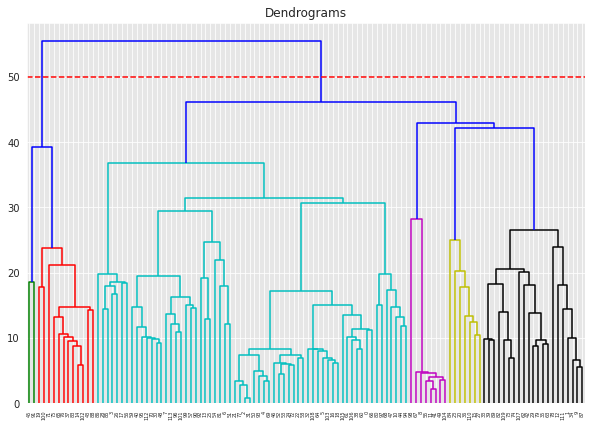

In [21]:

data=X=pca.transform(concatenate)[:,:10]
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data, method='single'))
plt.axhline(y=50, color='r', linestyle='--')

In [22]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')  
cluster.fit_predict(data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

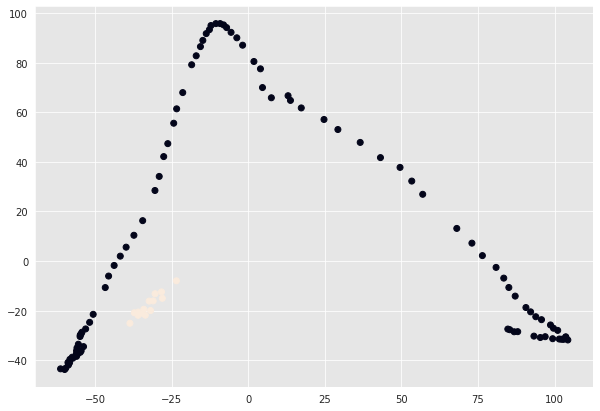

In [23]:
plt.figure(figsize=(10, 7))  
plt.scatter(X[:,0], X[:,1], c=cluster.labels_) 

In [24]:
individus=cluster.labels_.tolist()
indices=[]
for i in range(len(individus)):
  if individus[i]==0:
    indices.append(i)
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 72, 73, 74, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]


In [25]:
datatouse=X[indices,0:10]
imagestouse=imageconcatenate[indices]

## Find the shortest path using Principal Component, Neighbor Graph and TSP Problem

We create the graph using k neighbors with a complete graph

In [26]:
AX = kneighbors_graph(datatouse,99,mode='distance', include_self=False)
GX=nx.Graph(AX)

In [27]:
d = pd.DataFrame({
    "Dim1" : datatouse[:,0], 
    "Dim2" : datatouse[:,1],
    "index": [i for i in range(len(datatouse[:,1]))]
})

fig = px.scatter(d, x="Dim1", y="Dim2",text="index")
fig.show()

We chose '86' as the starting point from the solution of tsp

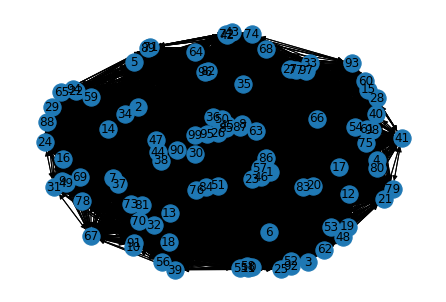

In [165]:
GX=nx.DiGraph(AX,vertex_size=300)
nx.draw(GX,with_labels=True)

In [28]:
tsp = nx.approximation.greedy_tsp
path=tsp(GX, source=86)


In [29]:
#to find a more optimal solution
path2=nx.approximation.simulated_annealing_tsp(GX,path,move='1-0',source=86)
path3=nx.approximation.threshold_accepting_tsp(GX,init_cycle=path2,source=86)

In [30]:
print(path3)

[86, 61, 8, 50, 38, 11, 90, 44, 69, 12, 1, 77, 9, 32, 97, 31, 36, 78, 73, 95, 67, 66, 33, 58, 70, 27, 39, 57, 93, 18, 96, 25, 14, 34, 21, 74, 24, 3, 75, 26, 16, 51, 76, 54, 37, 98, 64, 43, 28, 83, 84, 88, 99, 7, 79, 52, 87, 13, 23, 80, 49, 46, 6, 72, 71, 85, 62, 42, 10, 40, 82, 91, 60, 0, 56, 92, 35, 55, 15, 17, 89, 5, 59, 94, 30, 20, 53, 41, 65, 22, 48, 47, 45, 4, 63, 81, 19, 2, 29, 68, 86]


#Recreate video from order

In [35]:
def create_video(points,imageconcat, outfile):
    img_array=[]
    for point in reversed(points): #we realize that the starting point is the end point
        img = imageconcat[point]
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
    
    
    out = cv2.VideoWriter(outfile,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [38]:
create_video(path3[:-1],imagestouse, 'recreate_video.avi')
